In [9]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')
# Install required packages
!pip install -U sentence-transformers
# Import necessary libraries
import pandas as pd
from collections import Counter
from sentence_transformers import SentenceTransformer
import numpy as np
import sklearn
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    mean_squared_error, mean_absolute_error, classification_report, confusion_matrix
)
import seaborn as sn
import matplotlib.pyplot as plt
# Load datasets
# Adjusting to the comma-separated format and proper headers
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_200.csv")  # Train dataset has headers
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/mal_full_offe_test_MODIFY (1).csv", header=None, names=["text", "label"])  # Test dataset lacks headers
# Prepare data for training and testing
train_sent_m = train['text'].tolist()
train_label_m = train['label'].tolist()

test_sent_m = test['text'].tolist()
test_label_m = test['label'].tolist()
# Encode labels
from sklearn import preprocessing

# Initialize and fit LabelEncoder on the training labels
le = preprocessing.LabelEncoder()
train_labels_encoded = le.fit_transform(train_label_m)

# Add "unknown" explicitly to LabelEncoder classes
le.classes_ = np.append(le.classes_, "unknown")

# Ensure test labels only include known labels
# Replace unknown labels with "unknown" for proper transformation
known_labels = set(le.classes_)  # Includes "unknown" now
test_label_m_filtered = [label if label in known_labels else "unknown" for label in test_label_m]

# Encode the filtered test labels
test_labels_encoded = le.transform(test_label_m_filtered)

# Verify encoding
print("Classes in LabelEncoder:", le.classes_)
# Load multilingual embedding model
trans_model = SentenceTransformer('bert-base-multilingual-cased')
trans_model.max_seq_length = 128  # Reduce sequence length to speed up processing
# Generate embeddings
train_sentence_embeddings = trans_model.encode(train_sent_m)
test_sentence_embeddings = trans_model.encode(test_sent_m)
# Compute class weights to handle imbalance
class_weights = sklearn.utils.class_weight.compute_class_weight(
    'balanced', classes=np.unique(train_labels_encoded), y=train_labels_encoded
)
print("Computed class weights:", class_weights)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Classes in LabelEncoder: ['Not_offensive' 'Offensive_Untargetede' 'Offensive_target_insult_Group'
 'Offensive_target_insult_individual' 'not-malayalam' 'unknown']
Computed class weights: [ 0.22996382 14.73545455 15.00833333  8.33367609  2.51888112]



Evaluation Scores:
Macro Metrics:
Accuracy: 0.761
Precision: 0.353
Recall: 0.850
F1 Score: 0.368

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.75      0.85      1765
           1       0.17      0.62      0.27        29
           2       0.00      1.00      0.00         0
           3       0.00      1.00      0.00         0
           4       0.61      0.88      0.72       157

    accuracy                           0.76      1951
   macro avg       0.35      0.85      0.37      1951
weighted avg       0.94      0.76      0.83      1951

Predictions saved to 'Logistic_regression_predictions.csv'.


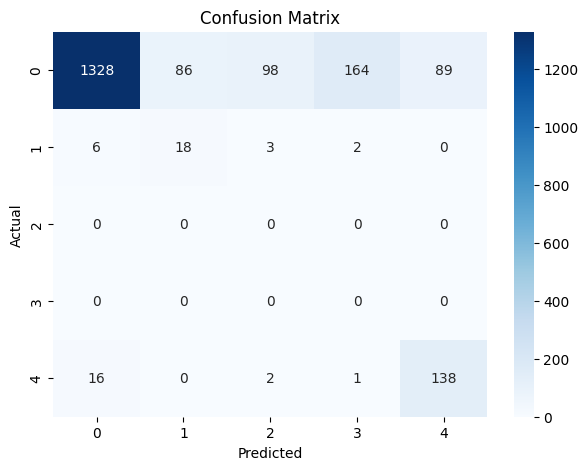

In [10]:
# Train Logistic Regression model
# Logistic Regression is a statistical model used for binary classification. It predicts the probability of a data point belonging to one of two classes based on
# input features, using a logistic (S-shaped) function to map predictions to probabilities.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt


# Map class weights into dictionary format
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
# class_weight_dict = {0:0.22607331, 1:23.54117647 ,2:13.69505703 ,3:17.07014218 ,4:2.484}


# Initialize and train the model
model = LogisticRegression(class_weight=class_weight_dict, max_iter=500)
model.fit(train_sentence_embeddings, train_labels_encoded)

# Predict on the test data
expected = test_labels_encoded
predicted = model.predict(test_sentence_embeddings)

# Handle unseen labels in the test data
# Map unseen test labels to a default class to avoid evaluation errors
unique_train_labels = np.unique(train_labels_encoded)
filtered_expected = [label if label in unique_train_labels else -1 for label in expected]
filtered_predicted = [pred if pred in unique_train_labels else -1 for pred in predicted]

# Remove the default class (-1) from filtered labels for evaluation
filtered_expected = np.array(filtered_expected)
filtered_predicted = np.array(filtered_predicted)
valid_indices = filtered_expected != -1
filtered_expected = filtered_expected[valid_indices]
filtered_predicted = filtered_predicted[valid_indices]

# Evaluate model
print("\nEvaluation Scores:")
accuracy = accuracy_score(filtered_expected, filtered_predicted)
recall = recall_score(filtered_expected, filtered_predicted, average="macro", zero_division=1)
precision = precision_score(filtered_expected, filtered_predicted, average="macro", zero_division=1)
f1 = f1_score(filtered_expected, filtered_predicted, average="macro", zero_division=1)

print("Macro Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

# Classification Report
# Fix LabelEncoder issue by fitting it on all possible labels before inverse_transform
all_possible_labels = np.unique(np.concatenate((train_labels_encoded, test_labels_encoded)))
le.fit(all_possible_labels)

# Convert target_names to strings
target_names = list(map(str, le.inverse_transform(unique_train_labels)))

print("\nClassification Report:")
print(classification_report(filtered_expected, filtered_predicted, labels=unique_train_labels, target_names=target_names, zero_division=1))

# Save predictions to a CSV file
# Fix: Ensure correct alignment of test inputs and predicted outputs in the DataFrame
try:
    predictions = le.inverse_transform(predicted)
except ValueError:
    predictions = ["unseen_label" if pred not in unique_train_labels else le.inverse_transform([pred])[0] for pred in predicted]

classified_df = pd.DataFrame({'tweets': test_sent_m, 'actual_label': test_label_m, 'predictions': list(predictions)})
classified_df.to_csv('Logistic_regression_predictions.csv', index=False)
print("Predictions saved to 'Logistic_regression_predictions.csv'.")

# Plot and save confusion matrix
cfm = confusion_matrix(filtered_expected, filtered_predicted, labels=unique_train_labels)
df_cfm = pd.DataFrame(cfm, index=target_names, columns=target_names)
plt.figure(figsize=(7, 5))
cfm_plot = sn.heatmap(df_cfm, annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("cfm_LR.png")
plt.show()

Evaluation Scores:
Macro Metrics:
Accuracy: 0.206
Precision: 0.271
Recall: 0.763
F1 Score: 0.162

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.14      0.24      1765
           1       0.04      0.83      0.07        29
           2       0.00      1.00      0.00         0
           3       0.00      1.00      0.00         0
           4       0.35      0.85      0.50       157

    accuracy                           0.21      1951
   macro avg       0.27      0.76      0.16      1951
weighted avg       0.90      0.21      0.26      1951

Predictions saved to 'Naive_Bayes_corrected_predictions.csv'.


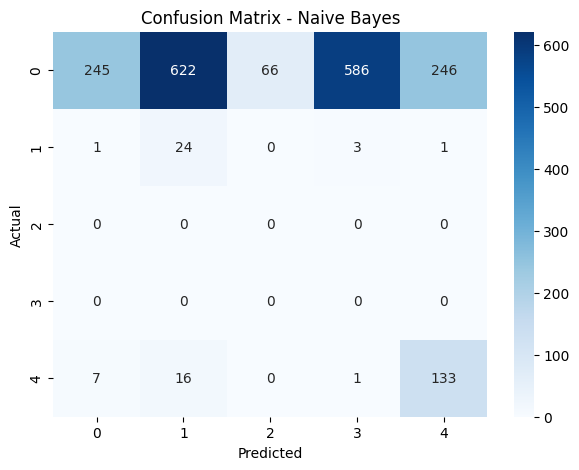

In [11]:
# Naive Bayes Implementation
# Naive Bayes is a probabilistic model based on Bayes' Theorem. It assumes that features are independent of each other (naive assumption) and calculates the
# likelihood of a data point belonging to a specific class based on these probabilities. It works well with text data and simple datasets.
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    classification_report, confusion_matrix
)
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

# Model Initialization
model = GaussianNB()  # You can switch to ComplementNB() for other NB variations.
model.fit(train_sentence_embeddings, train_labels_encoded)

# Use test labels and embeddings for evaluation
expected = test_labels_encoded  # Corrected variable
predicted = model.predict(test_sentence_embeddings)  # Use test embeddings

# Ensure consistent handling of unseen labels
unique_train_labels = np.unique(train_labels_encoded)
filtered_expected = [label if label in unique_train_labels else -1 for label in expected]
filtered_predicted = [pred if pred in unique_train_labels else -1 for pred in predicted]

filtered_expected = np.array(filtered_expected)
filtered_predicted = np.array(filtered_predicted)
valid_indices = filtered_expected != -1
filtered_expected = filtered_expected[valid_indices]
filtered_predicted = filtered_predicted[valid_indices]

# Evaluation Scores
print("Evaluation Scores:")
accuracy = accuracy_score(filtered_expected, filtered_predicted)
recall = recall_score(filtered_expected, filtered_predicted, average="macro", zero_division=1)
precision = precision_score(filtered_expected, filtered_predicted, average="macro", zero_division=1)
f1 = f1_score(filtered_expected, filtered_predicted, average="macro", zero_division=1)

print("Macro Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

# Classification Report
# Use unique_train_labels to ensure alignment with model output
target_names = list(map(str, le.inverse_transform(unique_train_labels)))

print("\nClassification Report:")
print(classification_report(filtered_expected, filtered_predicted, labels=unique_train_labels, target_names=target_names, zero_division=1))

# Save Predictions with Updated Logic
try:
    predictions = le.inverse_transform(predicted)  # Decode predictions
except ValueError:
    # Handle unseen labels
    predictions = [
        "unseen_label" if pred not in unique_train_labels else le.inverse_transform([pred])[0]
        for pred in predicted
    ]

# Ensure the output CSV is properly formatted
classified_df = pd.DataFrame({
    'tweets': test_sent_m,
    'actual_label': list(test_label_m),  # Ensure `test_label_m` is correctly mapped to string labels
    'predictions': list(predictions)
})

# Save the corrected predictions to CSV
output_csv_path = 'Naive_Bayes_corrected_predictions.csv'
classified_df.to_csv(output_csv_path, index=False)
print(f"Predictions saved to '{output_csv_path}'.")

# Confusion Matrix
cfm = confusion_matrix(filtered_expected, filtered_predicted, labels=unique_train_labels)
df_cfm = pd.DataFrame(cfm, index=target_names, columns=target_names)

plt.figure(figsize=(7, 5))
cfm_plot = sn.heatmap(df_cfm, annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("cfm_NB.png")
plt.show()

Eval Scores:
Macro Metrics:
Accuracy: 0.933
Precision: 0.439
Recall: 0.819
F1 Score: 0.428

Classification Report:
                                      precision    recall  f1-score   support

                       Not_offensive       0.97      0.96      0.96      1765
     Offensive_Targeted_Insult_Group       0.40      0.41      0.41        29
Offensive_Targeted_Insult_Individual       0.00      1.00      0.00         0
                Offensive_Untargeted       0.00      1.00      0.00         0
                       Not_Malayalam       0.83      0.72      0.77       157

                            accuracy                           0.93      1951
                           macro avg       0.44      0.82      0.43      1951
                        weighted avg       0.95      0.93      0.94      1951

Predictions saved to 'SVM_linear_labse_corrected.csv'.
Model saved to 'linear_labse_corrected.pkl'.


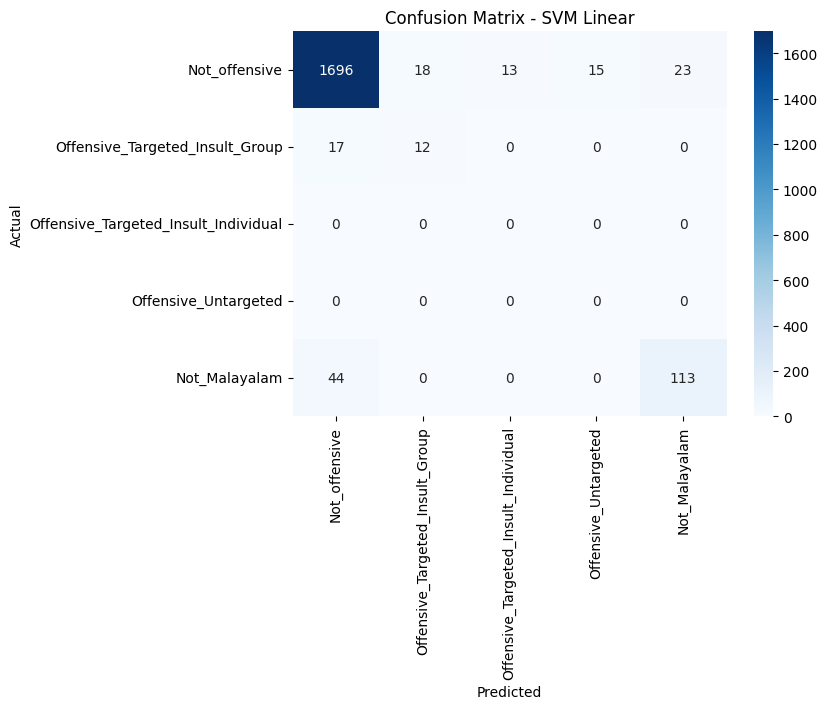

Confusion matrix saved as 'cfm_SVM_linear_corrected.png'.


In [12]:
# SVM Linear
# Linear SVM is a machine learning model that separates data into classes using a straight line (or hyperplane in higher dimensions). It aims to maximize the
# margin (distance) between the data points of different classes and the dividing line.
#model present
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import pickle

# Ensure required variables are defined
# train_sentence_embeddings, train_labels_encoded, dev_sentence_embeddings, dev_labels_encoded must be initialized
# test_sent_m and test_label_m are assumed to be defined for saving predictions

# Initialize and train the SVM model
model = SVC(kernel='linear', C=10)
model.fit(train_sentence_embeddings, train_labels_encoded)

# Predictions and handling unseen labels
expected = test_labels_encoded
predicted = model.predict(test_sentence_embeddings)

# Handle unseen labels (filter out invalid predictions)
unique_train_labels = np.unique(train_labels_encoded)
filtered_expected = [label if label in unique_train_labels else -1 for label in expected]
filtered_predicted = [pred if pred in unique_train_labels else -1 for pred in predicted]

filtered_expected = np.array(filtered_expected)
filtered_predicted = np.array(filtered_predicted)
valid_indices = filtered_expected != -1
filtered_expected = filtered_expected[valid_indices]
filtered_predicted = filtered_predicted[valid_indices]

# Evaluation Scores
print("Eval Scores:")
accuracy = accuracy_score(filtered_expected, filtered_predicted)
recall = recall_score(filtered_expected, filtered_predicted, average="macro", zero_division=1)
precision = precision_score(filtered_expected, filtered_predicted, average="macro", zero_division=1)
f1 = f1_score(filtered_expected, filtered_predicted, average="macro", zero_division=1)

print("Macro Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

# Classification Report
target_names = ['Not_offensive', 'Offensive_Targeted_Insult_Group',
                'Offensive_Targeted_Insult_Individual', 'Offensive_Untargeted', 'Not_Malayalam']
print("\nClassification Report:")
print(classification_report(filtered_expected, filtered_predicted, labels=unique_train_labels, target_names=target_names, zero_division=1))

# Save predictions
try:
    predictions = list(model.classes_[predicted])  # Decode predictions
except ValueError:
    predictions = [
        "unseen_label" if pred not in unique_train_labels else le.inverse_transform([pred])[0]
        for pred in predicted
    ]

classified_df = pd.DataFrame({
    'tweets': test_sent_m,
    'actual_label': list(test_label_m),  # Ensure test_label_m is correctly decoded
    'predictions': predictions
})

# Save predictions to a CSV
output_csv_path = 'SVM_linear_labse_corrected.csv'
classified_df.to_csv(output_csv_path, index=False)
print(f"Predictions saved to '{output_csv_path}'.")

# Save the trained model
pkl_filename = "linear_labse_corrected.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)
print(f"Model saved to '{pkl_filename}'.")

# Confusion Matrix
cfm = confusion_matrix(filtered_expected, filtered_predicted, labels=unique_train_labels)
df_cfm = pd.DataFrame(cfm, index=target_names, columns=target_names)

plt.figure(figsize=(7, 5))
cfm_plot = sn.heatmap(df_cfm, annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix - SVM Linear")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("cfm_SVM_linear_corrected.png")
plt.show()
print("Confusion matrix saved as 'cfm_SVM_linear_corrected.png'.")

Evaluation Scores:
Macro Metrics:
Accuracy: 0.937
Precision: 0.608
Recall: 0.705
F1 Score: 0.399

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1765
           1       0.78      0.48      0.60        29
           2       0.00      1.00      0.00         0
           3       0.00      1.00      0.00         0
           4       0.92      0.76      0.83       157

   micro avg       0.94      0.96      0.95      1951
   macro avg       0.53      0.85      0.48      1951
weighted avg       0.95      0.96      0.95      1951

Predictions saved to 'KNN_corrected_predictions.csv'.


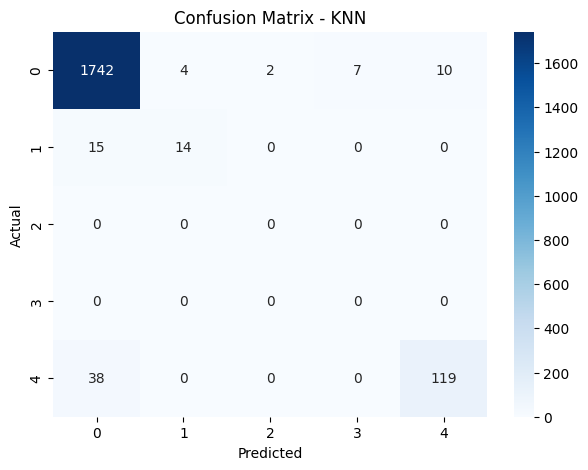

Confusion matrix saved as 'cfm_KNN_corrected.png'.


In [13]:
# KNN classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    classification_report, confusion_matrix
)
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import pickle

# Initialize and train the KNN model
model = KNeighborsClassifier(weights='distance')
model.fit(train_sentence_embeddings, train_labels_encoded)

# Make predictions
expected = test_labels_encoded
predicted = model.predict(test_sentence_embeddings)

# Evaluation Scores
print("Evaluation Scores:")
accuracy = accuracy_score(expected, predicted)
recall = recall_score(expected, predicted, average="macro", zero_division=1)
precision = precision_score(expected, predicted, average="macro", zero_division=1)
f1 = f1_score(expected, predicted, average="macro", zero_division=1)

print("Macro Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

# Classification Report
# Use the correct number of target names based on unique labels in your dataset
unique_labels = np.unique(train_labels_encoded)
target_names = list(map(str, le.inverse_transform(unique_labels)))

print("\nClassification Report:")
print(classification_report(expected, predicted, labels=unique_labels, target_names=target_names, zero_division=1))

# Save Predictions
predictions = list(le.inverse_transform(predicted))  # Decode predictions
classified_df = pd.DataFrame({
    'tweets': test_sent_m,
    'actual_label': list(test_label_m),
    'predictions': predictions
})

# Save predictions to a CSV file
output_csv_path = 'KNN_corrected_predictions.csv'
classified_df.to_csv(output_csv_path, index=False)
print(f"Predictions saved to '{output_csv_path}'.")

# Confusion Matrix
cfm = confusion_matrix(expected, predicted, labels=unique_labels)
df_cfm = pd.DataFrame(cfm, index=target_names, columns=target_names)

plt.figure(figsize=(7, 5))
cfm_plot = sn.heatmap(df_cfm, annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("cfm_KNN_corrected.png")
plt.show()
print("Confusion matrix saved as 'cfm_KNN_corrected.png'.")

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Clear session to avoid memory issues
tf.keras.backend.clear_session()

# Ensure LabelEncoder includes all known labels
le = LabelEncoder()
all_possible_labels = np.unique(np.concatenate((train_labels_encoded, test_labels_encoded)))
le.fit(all_possible_labels)

# Map unknown labels in the test set
known_labels = set(train_labels_encoded)
test_labels_mapped = [label if label in known_labels else -1 for label in test_labels_encoded]
test_labels_mapped = np.array(test_labels_mapped)

# Remove unknown labels (-1) for proper one-hot encoding
valid_indices = test_labels_mapped != -1
filtered_test_labels = test_labels_mapped[valid_indices]
filtered_test_embeddings = np.array(test_sentence_embeddings)[valid_indices]

# Convert labels to categorical format
num_classes = len(np.unique(train_labels_encoded))
y_train = to_categorical(train_labels_encoded, num_classes=num_classes)
y_test = to_categorical(filtered_test_labels, num_classes=num_classes)

# Reshape embeddings to match RNN input (batch_size, timesteps=1, features)
train_reshaped = np.array(train_sentence_embeddings).reshape(-1, 1, train_sentence_embeddings.shape[1])
test_reshaped = np.array(filtered_test_embeddings).reshape(-1, 1, train_sentence_embeddings.shape[1])

# Define RNN model
model = Sequential([
    Input(shape=(1, train_sentence_embeddings.shape[1])),  # Corrected input shape
    SimpleRNN(64, activation='relu', return_sequences=False),  # Reduced units to 64 for stability
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model with error handling and reduced batch size
try:
    # Further reduce batch size to 8
    model.fit(train_reshaped, y_train, epochs=2, batch_size=5, validation_data=(test_reshaped, y_test))
except tf.errors.ResourceExhaustedError:
    print("Resource exhausted! Try reducing batch size further or using a smaller model.")

# Predictions
predictions = model.predict(test_reshaped)
predicted_labels = np.argmax(predictions, axis=1)
actual_labels = np.argmax(y_test, axis=1)

# Classification Report
print("\nClassification Report:")
print(classification_report(actual_labels, predicted_labels))

# Confusion Matrix
cfm = confusion_matrix(actual_labels, predicted_labels)
target_names = list(map(str, np.unique(train_labels_encoded)))
df_cfm = pd.DataFrame(cfm, index=target_names, columns=target_names)
plt.figure(figsize=(7, 5))
sn.heatmap(df_cfm, annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix - RNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("cfm_RNN.png")
plt.show()

Epoch 1/2


FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-14-0a0824c947b1>", line 56, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_4593]